神經網路設計https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/

## LSTM
<img src = 'https://www.researchgate.net/profile/Savvas-Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell_W640.jpg'><br>
* 核心：透過閘門(Gate)做調控<br>
X_t = input value <br>
1. forget gate ：從上一層的輸出帶進來的資訊，以及這一層新增加的資訊，有多少比例要被忘掉，不被帶進下一層<br>
Ct-1 → Ct 表示 cell state(單元狀態)
2. input gate、更新主要單元：決定什麼要被記錄下來，以及更新的主要單元
3. output gate：從上一步驟的結果 Ct，再透過邏輯函數以及 tanh 的調控，來決定主要單元上要被輸出
<br>h(g(X)f(Xi)+cf(Xf))*f(Xo)

(資料來源 ：https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook <br>
流程：https://tengyuanchang.medium.com/%E6%B7%BA%E8%AB%87%E9%81%9E%E6%AD%B8%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF-rnn-%E8%88%87%E9%95%B7%E7%9F%AD%E6%9C%9F%E8%A8%98%E6%86%B6%E6%A8%A1%E5%9E%8B-lstm-300cbe5efcc3)

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # 標準化：StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/home/bettyliao/practice/data/IBM_2006-01-01_to_2018-01-01.csv',
                  index_col = 'Date', parse_dates = ['Date'])

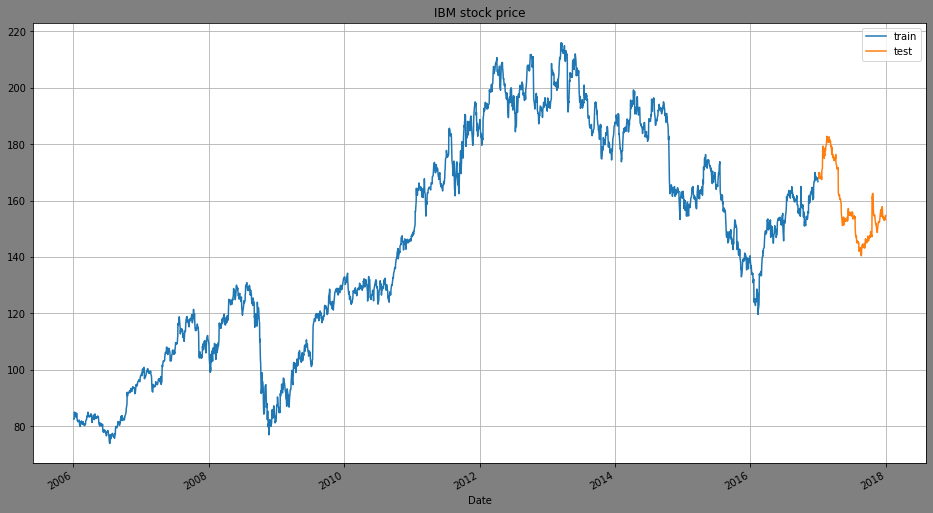

In [3]:
plt.figure(figsize = (16,9), facecolor = 'grey')
data['High'][:'2016'].plot(figsize = (16,9), legend = True)
data['High']['2017':].plot(figsize = (16,9), legend = True)
plt.legend(['train', 'test'])
plt.title('IBM stock price')
plt.grid()
plt.show()

In [4]:
# split train and test
train = data['High'][:'2016']
test = data['High']['2017':]

training = train.values.reshape(-1, 1)
# Scaling the training set
sc = MinMaxScaler(feature_range = (0,1))
training = sc.fit_transform(training)

In [5]:
# 60 previous training set elements
X_train = []
y_train = []
for i in range(60, 2769):
    X_train.append(training[i-60: i, 0])
    y_train.append(training[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train
X_train = np.reshape(X_train, (X_train.shape[0],
                               X_train.shape[1], 1))

In [6]:
model = Sequential()
"""
 set the layer
 LSTM ：
     return_state = True → 顯示c(t) cell 
     return_sequences = True → 顯示h(t)
     activation = hard_sigmoid
"""
# first
model.add(LSTM(units = 50, return_sequences = True,
               input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.2))
# second
model.add(LSTM(units = 50, return_sequences = True)) # 長度等同於timestep，表示網路輸出每個timestep的h(t)
model.add(Dropout(0.2))
# third
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#fourth
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [7]:
y_train.shape

(2709,)

In [8]:
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
85/85 [==============================] - 14s 94ms/step - loss: 0.0225
Epoch 2/50
85/85 [==============================] - 8s 94ms/step - loss: 0.0108
Epoch 3/50
85/85 [==============================] - 8s 95ms/step - loss: 0.0080
Epoch 4/50
85/85 [==============================] - 8s 95ms/step - loss: 0.0069
Epoch 5/50
85/85 [==============================] - 8s 95ms/step - loss: 0.0061
Epoch 6/50
85/85 [==============================] - 8s 95ms/step - loss: 0.0059
Epoch 7/50
85/85 [==============================] - 8s 95ms/step - loss: 0.0048
Epoch 8/50
85/85 [==============================] - 8s 95ms/step - loss: 0.0047
Epoch 9/50
85/85 [==============================] - 8s 95ms/step - loss: 0.0044
Epoch 10/50
85/85 [==============================] - 9s 104ms/step - loss: 0.0036
Epoch 11/50
85/85 [==============================] - 9s 104ms/step - loss: 0.0037
Epoch 12/50
85/85 [==============================] - 8s 98ms/step - loss: 0.0035
Epoch 13/50
85/85 [===============

In [9]:
type(test)

pandas.core.series.Series

In [10]:
total = pd.concat((data["High"][:'2016'],data["High"]['2017':]),axis=0)
inputs = total[len(total)-len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [11]:
inputs.shape

(311, 1)

In [13]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
test = pd.DataFrame(test, columns = ['High'])
test['predict'] = predicted_stock_price
mean_squared_error(test['High'], test['predict'])

8.963097622207925

In [18]:
def plot_predictions(test,predicted):
    plt.figure(figsize = (16,9), facecolor = 'grey')
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

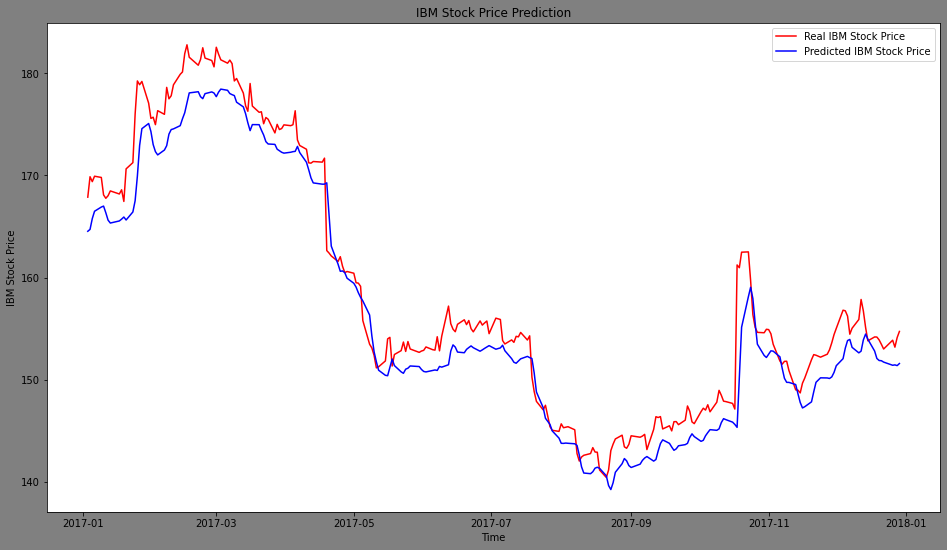

In [19]:
plot_predictions(test['High'], test['predict'])

## GRU
<img src = 'https://i2.wp.com/clay-atlas.com/wp-content/uploads/2020/06/image-6.png?fit=640%2C311&ssl=1'><br>
* LSTM 之變形，forget gate和input gate組合為 update gate，單元狀態和隱藏狀態合併

In [22]:
# GRU model
model_GRU = Sequential()
# first 
model_GRU.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1),
                 activation = 'tanh'))
model_GRU.add(Dropout(0.2)) # Drop 20%
# second
model_GRU.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1),
                 activation = 'tanh'))
model_GRU.add(Dropout(0.2)) 
#third
model_GRU.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1),
                 activation = 'tanh'))
model_GRU.add(Dropout(0.2)) 
#fourth
model_GRU.add(GRU(units = 50, activation = 'tanh'))
model_GRU.add(Dropout(0.2)) 
# out
model_GRU.add(Dense(units = 1))
model_GRU.compile(optimizer = SGD(lr = 0.01, decay = 1e-7,
                                 momentum = 0.9, nesterov = False),
                 loss = 'mean_squared_error')
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 60, 50)            7950      
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_6 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 50)               

In [23]:
model_GRU.fit(X_train, y_train, epochs = 50, batch_size = 150)

Epoch 1/50
19/19 [==============================] - 9s 155ms/step - loss: 0.1169
Epoch 2/50
19/19 [==============================] - 3s 153ms/step - loss: 0.0436
Epoch 3/50
19/19 [==============================] - 3s 153ms/step - loss: 0.0163
Epoch 4/50
19/19 [==============================] - 3s 163ms/step - loss: 0.0053
Epoch 5/50
19/19 [==============================] - 3s 171ms/step - loss: 0.0046
Epoch 6/50
19/19 [==============================] - 3s 170ms/step - loss: 0.0041
Epoch 7/50
19/19 [==============================] - 3s 171ms/step - loss: 0.0039
Epoch 8/50
19/19 [==============================] - 3s 171ms/step - loss: 0.0036
Epoch 9/50
19/19 [==============================] - 3s 170ms/step - loss: 0.0035
Epoch 10/50
19/19 [==============================] - 3s 168ms/step - loss: 0.0030
Epoch 11/50
19/19 [==============================] - 3s 154ms/step - loss: 0.0032
Epoch 12/50
19/19 [==============================] - 3s 153ms/step - loss: 0.0030
Epoch 13/50
19/19 [======

In [29]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = model_GRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
test['GRU_predict'] = GRU_predicted_stock_price
mean_squared_error(test['High'], test['GRU_predict'])

9.8263836774925

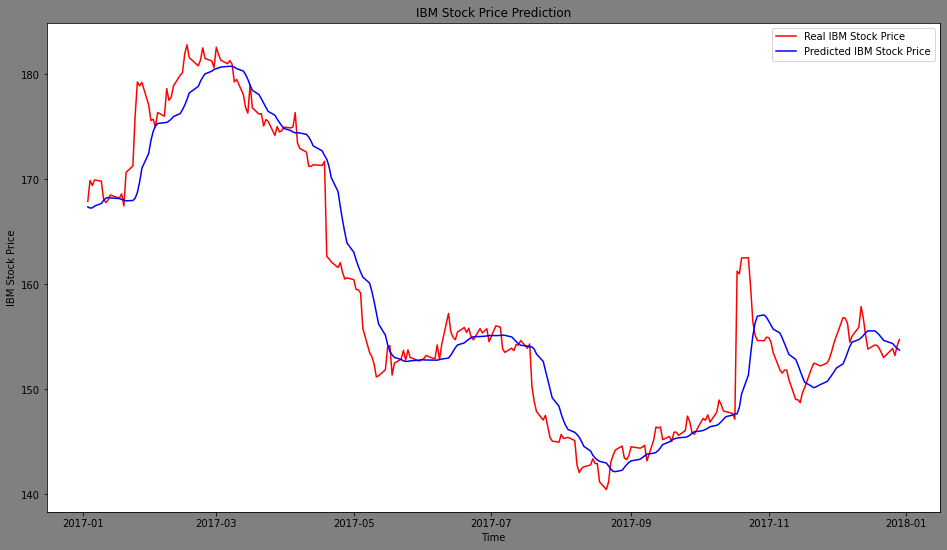

In [30]:
plot_predictions(test['High'], test['GRU_predict'])